In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import QuantLib as ql
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

options = webdriver.ChromeOptions()
options.add_argument('headless') # headless: 브라우저가 안뜸

driver = webdriver.Chrome('C:\\Users\\inventor\\Desktop\\FR study\\FR-30th\\Bond_study\\FR_30_NIH\\chromedriver.exe', options=options)
URL="https://www.wsj.com/market-data/bonds"
driver.get(URL)

def GET_DATE():
    # url = "https://www.wsj.com/market-data/bonds"
    # req = requests.get(url,headers=headers)
    # html = req.content
    # soup = BeautifulSoup(html, 'html.parser')
    source = driver.page_source
    soup = BeautifulSoup(source, 'html.parser')
    data = soup.select('div > div > div > div > div > div > div > div > h3 > span')
    # print(data)
    date = data[1].text
    # print(date[-8:])
    if date[-8]=='1':
        date = datetime.datetime.strptime(str(date[-8:]), "%m/%d/%y")
    else:
        date = datetime.datetime.strptime(str(date[-7:]), "%m/%d/%y")
    print(date)
    return date
    
def GET_QUOTE(reference_date):
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y', '05Y', '07Y', '10Y', '30Y']
    
    # Create Empty Lists
    maturities = []
    days = []
    prices = []
    coupons = []

    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

    # Get Market Information    
    for i, tenor in enumerate(tenors):
        url = "https://quotes.wsj.com/bond/BX/TMUBMUSD" + tenor + "?mod=md_bond_overview_quote"
        req = requests.get(url, headers=headers)
        html = req.content
        soup = BeautifulSoup(html, 'html.parser')
        
        # Price
        if i <= 3:
            data_src = soup.find("span", id="quote_val")
            price = data_src.text
            price = float(price[:-1])
        else:
            data_src = soup.find("span", id="price_quote_val")
            price = data_src.text
            price = price.split()
            price1 = float(price[0])
            price = price[1].split('/')
            price2 = float(price[0])
            price3 = float(price[1])            
            price = price1 + (price2 / price3)  
            
        data_src2 = soup.find_all("span", class_="data_data")
        
        # Coupon
        coupon = data_src2[2].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
        
        # Maturity Date
        maturity = data_src2[3].text
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y')
        
        # Send to Lists
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    # Create DataFrame
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)
    
    return df


def TREASURY_CURVE(date, quote):
    
    # Divide Quotes
    tbill = quote[0:4]
    tbond = quote[4:]
    
    # Set Evaluation Date
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date
    
    # Set Market Conventions
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = False
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)

    bill_helpers = 
    # [ql.DepostiRateHelper(x,y) for x,y in zip(a,b)]
    # [f(x(0),y(0)),f(x(1)),f(y(1)),...]
    # Construct Treasury Bill Helpers
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                         ql.Period(m, ql.Days),
                                         fixing_days,
                                         calendar,
                                         convention,
                                         end_of_month,
                                         day_counter) 
                            for r, m in zip(tbill['price'], tbill['days'])]
    
    # Construct Treasury Bond Helpers
    bond_helpers = []

    # bond_helpers = [F(p(0),c(0),m(0)), F(p(1),c(1),m(1)),...]
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                               termination_date,
                               coupon_frequency,
                               calendar,
                               convention,
                               convention,
                               ql.DateGeneration.Backward,
                               end_of_month)
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                             fixing_days,
                                             face_amount,
                                             schedule,
                                             [c/100.0],
                                             day_counter,
                                             convention)
        bond_helpers.append(bond_helper)
    
    # Bind Helpers
    rate_helper = bill_helpers + bond_helpers
    
    # Build Curve
    yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)
    
    return yc_linearzero

def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate






2020-07-09 00:00:00
2020-07-09 00:00:00
            discount factor  zero rate
maturity                              
2020-08-04         0.999925   0.001050
2020-10-08         0.999684   0.001270
2021-01-07         0.999254   0.001502
2021-06-17         0.998472   0.001630
2022-06-30         0.990355   0.004916
2023-07-15         0.988751   0.003756
2025-06-30         0.980198   0.004025
2027-06-30         0.965995   0.004967
2030-05-15         0.932278   0.007133
2050-05-15         0.643239   0.014838


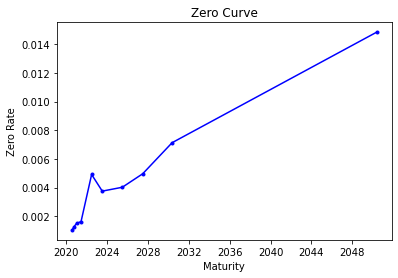

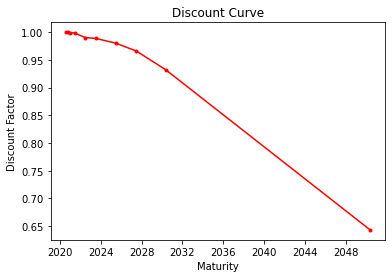

In [3]:
ref_date = GET_DATE()
print(ref_date)
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)
    
quote['discount factor'] = np.nan
quote['zero rate'] = np.nan
    
for date in quote.index:
    quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
    quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)
        
print(quote[['discount factor', 'zero rate']])
    
plt.figure(figsize=(6, 4))
plt.plot(quote['zero rate'], 'b.-')
plt.title('Zero Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate')
    
plt.figure(figsize=(6, 4))
plt.plot(quote['discount factor'], 'r.-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')

plt.show()

In [4]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# # Plotting 
trace = go.Scatter(x=quote.index, y=quote['discount factor']) 
layout = go.Layout(title='Discount Curve', xaxis=dict(title='Maturity'), yaxis=dict(title='Zero Rate'),width=600, height=400)
data1=[trace] 
fig1 = dict(data=data1, layout=layout)
iplot(fig1)

In [5]:
print(quote['discount factor'])
print(quote.index)

# # Plotting 
trace = go.Scatter(x=quote.index, y=quote['discount factor']) 
layout = go.Layout( title='Dyanmic Visualization of Discout Curve', 
                    xaxis=dict( 
                        rangeselector=dict( 
                            buttons=list(
                                [ dict(count=1, label='1m', step='month', stepmode='backward'), dict(count=3, label='3m', step='month', stepmode='backward'), dict(count=6, label='6m', step='month', stepmode='backward'), dict(step='all') ]) 
                                ), 
                        rangeslider=dict(visible=True), 
                        type='date',
                        title='Maturity'
                        ),
                    yaxis=dict(title='Zero Rate'),
                    width=600, height=400
                    )

data1=[trace] 
fig1 = dict(data=data1, layout=layout)
iplot(fig1)


maturity
2020-08-04    0.999925
2020-10-08    0.999684
2021-01-07    0.999254
2021-06-17    0.998472
2022-06-30    0.990355
2023-07-15    0.988751
2025-06-30    0.980198
2027-06-30    0.965995
2030-05-15    0.932278
2050-05-15    0.643239
Name: discount factor, dtype: float64
DatetimeIndex(['2020-08-04', '2020-10-08', '2021-01-07', '2021-06-17',
               '2022-06-30', '2023-07-15', '2025-06-30', '2027-06-30',
               '2030-05-15', '2050-05-15'],
              dtype='datetime64[ns]', name='maturity', freq=None)
